In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn import preprocessing
from sklearn import tree
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
#load NCAA data
ncaa = pd.read_csv('ncaa_player_stats.csv')

#drop rows without ncaa data
ncaa.dropna(subset=['NCAA_games'], inplace=True)

#select relevant rows
ncaa = ncaa[['college', 'height', 'name', 'position', 'weight', 
'NCAA__3ptapg', 'NCAA__3ptpct', 'NCAA__3ptpg', 'NCAA_fgapg',
'NCAA_fgpct', 'NCAA_fgpg', 'NCAA_ft', 'NCAA_ftapg', 'NCAA_ftpg', 'NCAA_games', 'NCAA_ppg']]

#print(ncaa)

In [3]:
#load NBA data
nba = pd.read_csv('nba_player_stats.csv')

#only past 20 years
nba = nba.loc[nba['Year']>=2004,:]

#print(nba)

In [4]:
rookies = pd.DataFrame(columns=['name', 'PER', 'rookie_year','age'])

for i in range(len(nba['Player'].unique())):
    p = nba['Player'].unique()[i]
    player = nba.loc[nba['Player']==p,:]
    
    player.reset_index(inplace=True)
    first_year = player.loc[0,'Year']

    average_per = player['PER'].mean()
    
    rookies.loc[i,'name'] = player.loc[0,'Player']
    rookies.loc[i,'PER'] = average_per
    rookies.loc[i,'rookie_year'] = int(first_year)
    rookies.loc[i,'age'] = int(player.loc[0,'Age'])

print(rookies)

                     name        PER rookie_year age
0     Shareef Abdur-Rahim  16.014286        2004  27
1             Malik Allen  10.041667        2004  25
2               Ray Allen  17.636364        2004  28
3            Rafer Alston  12.336364        2004  27
4          Chris Andersen  15.766667        2004  25
...                   ...        ...         ...  ..
1419        Troy Williams   9.766667        2017  22
1420         Kyle Wiltjer        6.7        2017  24
1421    Stephen Zimmerman        7.3        2017  20
1422          Paul Zipser        6.9        2017  22
1423          Ivica Zubac       17.0        2017  19

[1424 rows x 4 columns]


In [78]:
data = pd.merge(rookies, ncaa)

In [79]:
#manage null values - assuming these columns mean no data present = no points scored
data.loc[data['NCAA__3ptapg'].isnull(),'NCAA__3ptapg']=0
data.loc[data['NCAA_ftapg'].isnull(),'NCAA_ftapg']=0
data.loc[data['NCAA_fgapg'].isnull(),'NCAA_fgapg']=0
data.loc[data['NCAA__3ptpg'].isnull(),'NCAA__3ptpg']=0
data.loc[data['NCAA_ft'].isnull(),'NCAA_ft']=0

#2 null values still in PER column - drop
data.dropna(subset=['PER'], inplace=True)

data['NCAA__3ptpct'].fillna(0.0, inplace=True)

#column with missing values - to be aware of
for c in data.columns:
    if sum(data[c].isna())>0:
        print(c)
        print(sum(data[c].isna()))
        
data.reset_index(inplace=True)

data['NBA_Success'] = data['PER'].apply(lambda x: 1 if x > 17 else 0)

In [80]:
#convert height to inches
for i in range(len(data)):
    l = data['height'][i].split('-')
    data.loc[i, 'height']=int(l[0])*12+int(l[1])

In [81]:
data = data.rename(columns={'height':'Height',
          'weight':'Weight',
          'NCAA__3ptapg':'3-point Attempts per Game',
                     'NCAA__3ptpct':'3-Pointer %',
                     'NCAA__3ptpg': '3-Pointers per Game',
                     'NCAA_fgapg': 'Field Goal Attempts per Game',
                     'NCAA_fgpct': 'Field Goal %',
                     'NCAA_fgpg': 'Field Goals per Game',
                     'NCAA_ft': 'Free Throw %',
                     'NCAA_ftapg': 'Free Throw Attempts per Game',
                     'NCAA_ftpg': 'Free Throws Made per Game',
                     'NCAA_games': 'Total Games in NCAA',
                     'NCAA_ppg': 'NCAA Points per game'})

In [82]:
f = ['F', 'F-C', 'C-F', 'F-G', 'G-F']
g = ['G', 'F-G', 'G-F']
c = ['F-C', 'C-F', 'C']

In [83]:
#data = data[data['position'].isin(g)]

In [99]:
# Select features and target variable
features = ['Height','Weight', 
'3-point Attempts per Game', '3-Pointer %', '3-Pointers per Game', 'Field Goal Attempts per Game',
'Field Goal %', 'Field Goals per Game', 'Free Throw %', 'Free Throw Attempts per Game', 'Free Throws Made per Game', 
            'Total Games in NCAA', 'NCAA Points per game']

X = data[features]


y = data['NBA_Success']

# Split the data into training and test sets (60% training, 40% validation/test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_train

,Height,Weight,3-point Attempts per Game,3-Pointer %,3-Pointers per Game,Field Goal Attempts per Game,Field Goal %,Field Goals per Game,Free Throw %,Free Throw Attempts per Game,Free Throws Made per Game,Total Games in NCAA,NCAA Points per game
350,79,245.0,0.1,0.167,0.0,12.4,0.583,7.2,0.672,6.8,4.5,91.0,19.0
554,81,186.0,2.6,0.356,0.9,8.2,0.480,4.0,0.708,3.6,2.5,108.0,11.3
464,82,230.0,0.2,0.273,0.0,11.6,0.500,5.8,0.753,6.8,5.1,122.0,16.8
5,72,168.0,4.6,0.374,1.7,18.2,0.473,8.6,0.787,5.1,4.0,65.0,23.0
310,81,256.0,0.0,0.000,0.0,6.8,0.600,4.1,0.598,4.8,2.9,122.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1044,79,210.0,3.8,0.403,1.5,8.4,0.428,3.6,0.751,2.8,2.1,144.0,10.8
1095,77,183.0,1.9,0.299,0.6,9.3,0.535,5.0,0.814,5.5,4.5,68.0,15.0
1130,82,230.0,0.0,0.000,0.0,8.6,0.577,5.0,0.715,2.8,2.0,148.0,11.9
860,83,229.0,0.2,0.208,0.0,8.8,0.497,4.4,0.484,3.2,1.6,109.0,10.3


In [116]:



# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)
linear_importance = pd.Series(linear_model.coef_, index=features)
print("Linear Regression Coefficients:")
print(linear_importance)

# Logistic Regression
logistic_model = LogisticRegression()
logistic_model.fit(X_train_scaled, y_train)
logistic_importance = pd.Series(logistic_model.coef_[0], index=features)
print("\nLogistic Regression Coefficients:")
print(logistic_importance)

# Lasso Regression with Cross-Validation
lasso_model = LassoCV(cv=5)
lasso_model.fit(X_train_scaled, y_train)
lasso_importance = pd.Series(lasso_model.coef_, index=features)
print("\nLasso Regression Coefficients:")
print(lasso_importance)

# Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train_scaled, y_train)
gb_importance = pd.Series(gb_model.feature_importances_, index=features)
print("\nGradient Boosting Feature Importances:")
print(gb_importance)

Linear Regression Coefficients:
Height                         -0.025047
Weight                          0.031574
3-point Attempts per Game       0.007292
3-Pointer %                    -0.005518
3-Pointers per Game             0.112909
Field Goal Attempts per Game   -0.129498
Field Goal %                    0.002564
Field Goals per Game            0.424443
Free Throw %                   -0.056048
Free Throw Attempts per Game   -0.147688
Free Throws Made per Game       0.325315
Total Games in NCAA            -0.021929
NCAA Points per game           -0.451187
dtype: float64

Logistic Regression Coefficients:
Height                         -0.275838
Weight                          0.337019
3-point Attempts per Game      -0.060152
3-Pointer %                    -0.041211
3-Pointers per Game             0.308682
Field Goal Attempts per Game   -0.244387
Field Goal %                    0.537301
Field Goals per Game            0.142048
Free Throw %                   -0.241737
Free Throw Attem

C:\Users\mtoll\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006268568431288202, tolerance: 0.0033689839572192512
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\mtoll\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011738066166604, tolerance: 0.0033689839572192512
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\mtoll\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013408649094600378, tolerance: 0.0033689839572192512
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\mtoll\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_

C:\Users\mtoll\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10220064733835699, tolerance: 0.0038003565062388585
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\mtoll\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10351644062536991, tolerance: 0.0038003565062388585
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\mtoll\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10394317374505135, tolerance: 0.0038003565062388585
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\mtoll\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_

C:\Users\mtoll\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6833487487135024, tolerance: 0.003456405693950178
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\mtoll\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6837816572369881, tolerance: 0.003456405693950178
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\mtoll\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6838608826563579, tolerance: 0.003456405693950178
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\mtoll\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descen


Lasso Regression Coefficients:
Height                         -0.000000
Weight                          0.004802
3-point Attempts per Game       0.000000
3-Pointer %                    -0.000000
3-Pointers per Game             0.000000
Field Goal Attempts per Game    0.000000
Field Goal %                    0.030719
Field Goals per Game            0.000000
Free Throw %                   -0.000000
Free Throw Attempts per Game    0.000000
Free Throws Made per Game       0.023127
Total Games in NCAA            -0.013724
NCAA Points per game            0.000000
dtype: float64

Gradient Boosting Feature Importances:
Height                          0.023708
Weight                          0.113629
3-point Attempts per Game       0.033250
3-Pointer %                     0.052323
3-Pointers per Game             0.064851
Field Goal Attempts per Game    0.052556
Field Goal %                    0.179476
Field Goals per Game            0.051132
Free Throw %                    0.131680
Free Throw 

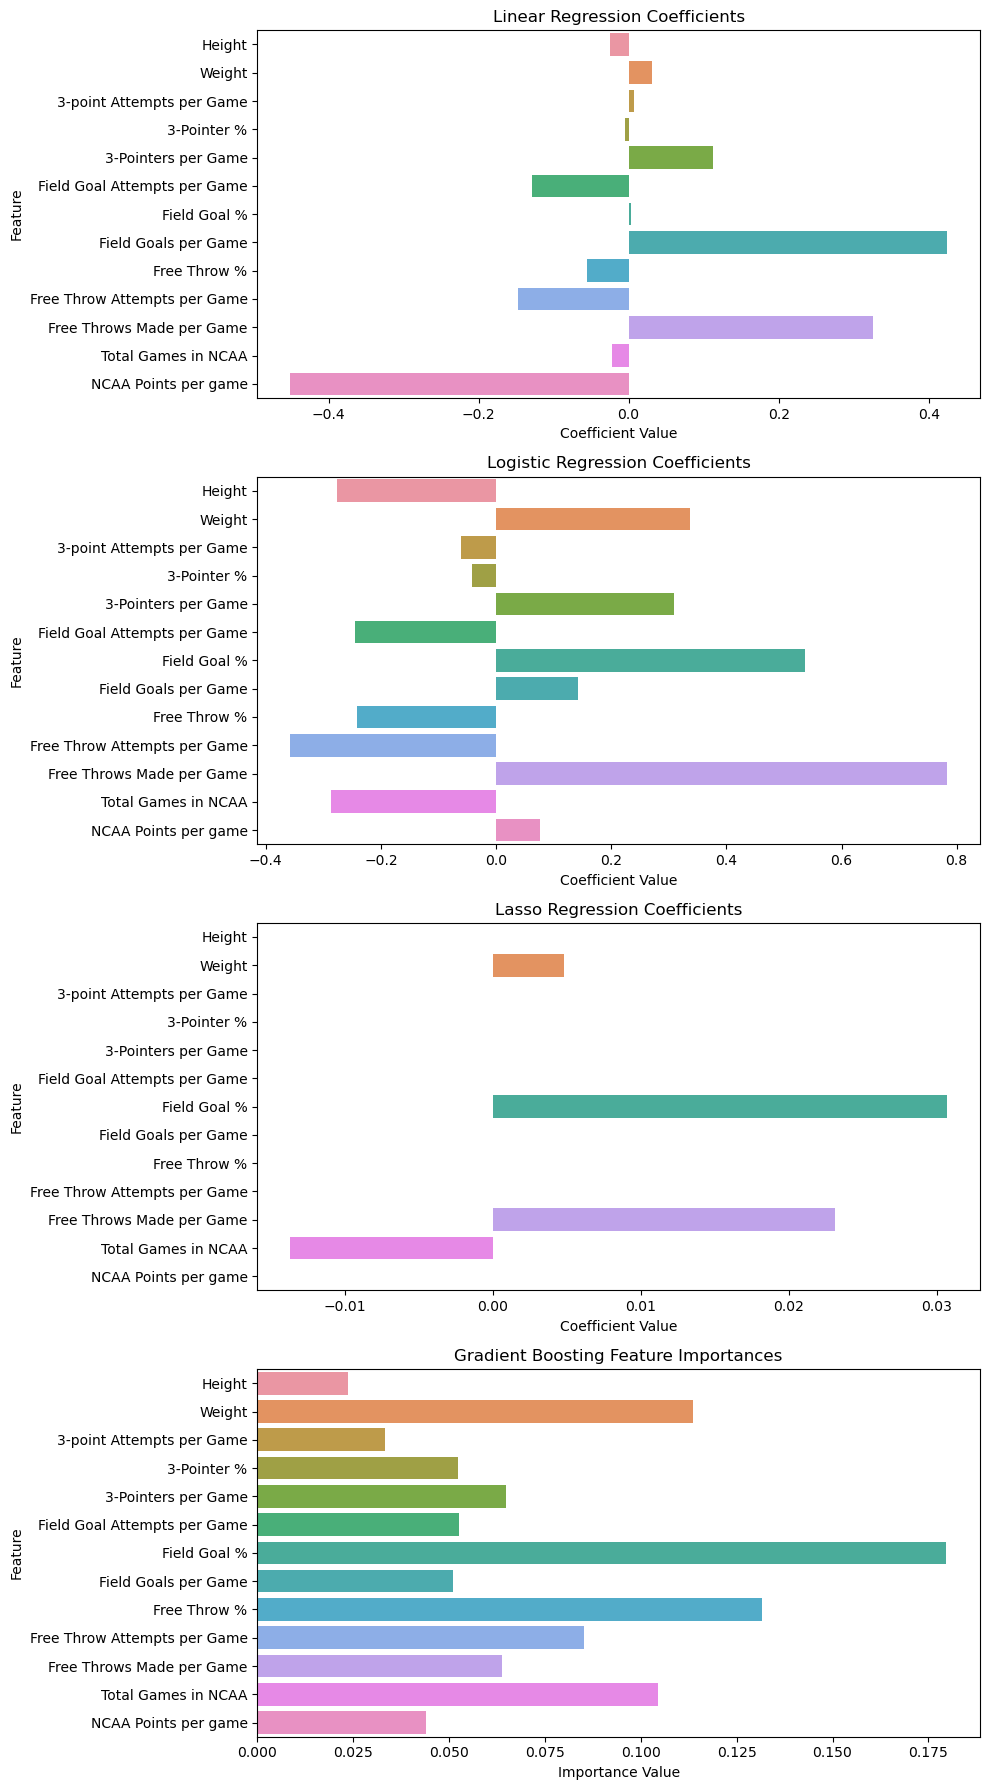

In [101]:
# Visualization
fig, axes = plt.subplots(4, 1, figsize=(10, 18))

# Linear Regression Coefficients
sns.barplot(x=linear_importance.values, y=linear_importance.index, ax=axes[0])
axes[0].set_title('Linear Regression Coefficients')
axes[0].set_xlabel('Coefficient Value')
axes[0].set_ylabel('Feature')

# Logistic Regression Coefficients
sns.barplot(x=logistic_importance.values, y=logistic_importance.index, ax=axes[1])
axes[1].set_title('Logistic Regression Coefficients')
axes[1].set_xlabel('Coefficient Value')
axes[1].set_ylabel('Feature')

# Lasso Regression Coefficients
sns.barplot(x=lasso_importance.values, y=lasso_importance.index, ax=axes[2])
axes[2].set_title('Lasso Regression Coefficients')
axes[2].set_xlabel('Coefficient Value')
axes[2].set_ylabel('Feature')

# Gradient Boosting Feature Importances
sns.barplot(x=gb_importance.values, y=gb_importance.index, ax=axes[3])
axes[3].set_title('Gradient Boosting Feature Importances')
axes[3].set_xlabel('Importance Value')
axes[3].set_ylabel('Feature')

plt.tight_layout()
plt.show()

In [114]:
# Choose a Model

from sklearn.metrics import mean_squared_error, accuracy_score


# Split the data into validation and test sets (50% validation, 50% test)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

y_val_pred_linear = linear_model.predict(X_val_scaled)
linear_mse = mean_squared_error(y_val, y_val_pred_linear)
linear_r2 = linear_model.score(X_val_scaled, y_val)

y_val_pred_logistic = logistic_model.predict(X_val_scaled)
logistic_accuracy = accuracy_score(y_val, y_val_pred_logistic)

y_val_pred_lasso = lasso_model.predict(X_val_scaled)
lasso_mse = mean_squared_error(y_val, y_val_pred_lasso)
lasso_r2 = lasso_model.score(X_val_scaled, y_val)

y_val_pred_gb = gb_model.predict(X_val_scaled)
gb_accuracy = accuracy_score(y_val, y_val_pred_gb)

# Print validation metrics
print("Linear Regression Validation MSE:", linear_mse)
print("Linear Regression Validation R^2:", linear_r2)
print("Logistic Regression Validation Accuracy:", logistic_accuracy)
print("Lasso Regression Validation MSE:", lasso_mse)
print("Lasso Regression Validation R^2:", lasso_r2)
print("Gradient Boosting Validation Accuracy:", gb_accuracy)

# Choose the best model based on validation performance
models = {
    'Linear Regression': {'model': linear_model, 'mse': linear_mse, 'r2': linear_r2},
    'Logistic Regression': {'model': logistic_model, 'accuracy': logistic_accuracy},
    'Lasso Regression': {'model': lasso_model, 'mse': lasso_mse, 'r2': lasso_r2},
    'Gradient Boosting': {'model': gb_model, 'accuracy': gb_accuracy}
}

# Select the best model based on MSE for regression and accuracy for classification
best_model_name = None
best_model_performance = None

for model_name, model_info in models.items():
    if 'mse' in model_info and (best_model_performance is None or model_info['mse'] < best_model_performance):
        best_model_name = model_name
        best_model_performance = model_info['mse']
    elif 'accuracy' in model_info and (best_model_performance is None or model_info['accuracy'] > best_model_performance):
        best_model_name = model_name
        best_model_performance = model_info['accuracy']

print(f"\nBest Model: {best_model_name} with performance: {best_model_performance}")

Linear Regression Validation MSE: 0.08981969402462041
Linear Regression Validation R^2: 0.14103748653927595
Logistic Regression Validation Accuracy: 0.8813559322033898
Lasso Regression Validation MSE: 0.0944824537905621
Lasso Regression Validation R^2: 0.0964466438325643
Gradient Boosting Validation Accuracy: 0.8813559322033898

Best Model: Gradient Boosting with performance: 0.8813559322033898



Gradient Boosting Test Accuracy: 0.8620689655172413

Gradient Boosting Feature Importances on Test Set:
Field Goal %                    0.179476
Free Throw %                    0.131680
Weight                          0.113629
Total Games in NCAA             0.104478
Free Throw Attempts per Game    0.085228
3-Pointers per Game             0.064851
Free Throws Made per Game       0.063737
Field Goal Attempts per Game    0.052556
3-Pointer %                     0.052323
Field Goals per Game            0.051132
NCAA Points per game            0.043953
3-point Attempts per Game       0.033250
Height                          0.023708
dtype: float64


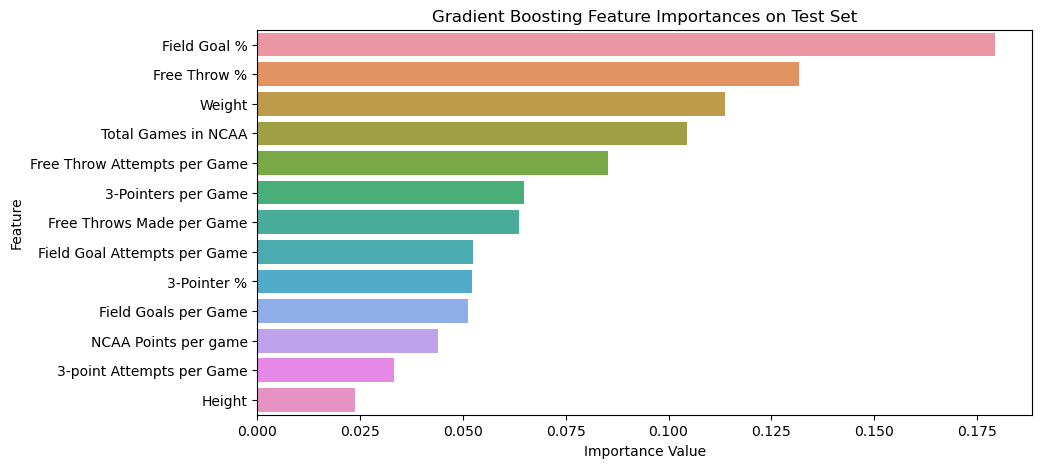

In [115]:
y_test_pred = gb_model.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"\n{best_model_name} Test Accuracy: {test_accuracy}")

gb_importance = pd.Series(models[best_model_name]['model'].feature_importances_, index=features)
gb_importance = gb_importance.sort_values(ascending=False)

print("\nGradient Boosting Feature Importances on Test Set:")
print(gb_importance)

# Visualization
plt.figure(figsize=(10, 5))
sns.barplot(x=gb_importance.values, y=gb_importance.index)
plt.title('Gradient Boosting Feature Importances on Test Set')
plt.xlabel('Importance Value')
plt.ylabel('Feature')
plt.show()

In [104]:
color = []
for i in range(len(logistic_importance)):
    if logistic_importance[i] > 0:
        color.append(1)
    else:
        color.append(-1)
        
color

[-1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1]


Logistic Regression Test Accuracy: 0.8803418803418803

Logistic Regression Feature Importances on Test Set:
Free Throws Made per Game       0.783500
Field Goal %                    0.537301
Free Throw Attempts per Game    0.357823
Weight                          0.337019
3-Pointers per Game             0.308682
Total Games in NCAA             0.286225
Height                          0.275838
Field Goal Attempts per Game    0.244387
Free Throw %                    0.241737
Field Goals per Game            0.142048
NCAA Points per game            0.076897
3-point Attempts per Game       0.060152
3-Pointer %                     0.041211
dtype: float64


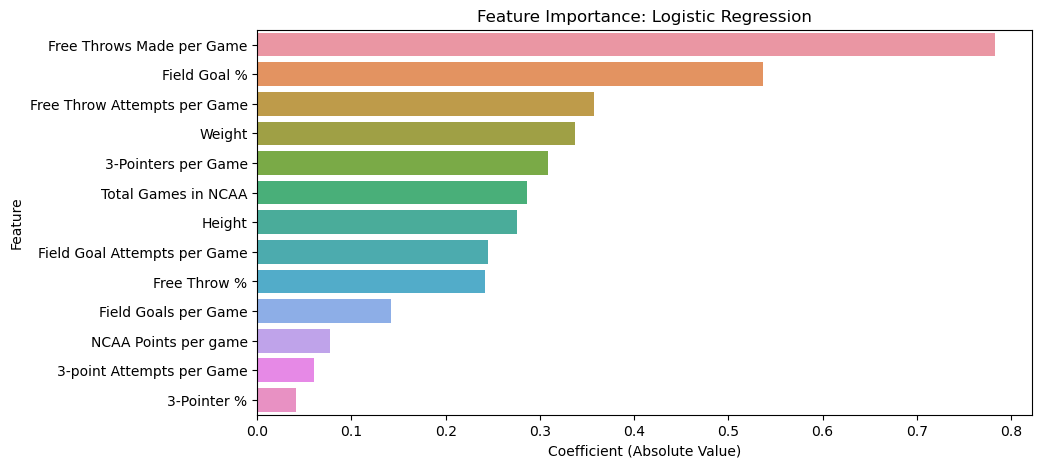

In [107]:
best_model_name = 'Logistic Regression'
y_test_pred = logistic_model.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"\n{best_model_name} Test Accuracy: {test_accuracy}")


#logit_importance = pd.Series(models[best_model_name]['model'].feature_importances_, index=features)
logit_importance = abs(logistic_importance).sort_values(ascending=False)

#gb_importance.index = ['Field goal %', 'Free throw %', 'Weight', '# Games in NCAA', 'Free throw attempts per game', 
 #'3-PT scored per game', 'Free throws scored per game', 'Field goal attempts per game',
 #'3-PT %', 'Field goals scored per game', 'Total points per game', '3-PT attempts per game', 'Height']

print("\nLogistic Regression Feature Importances on Test Set:")
print(logit_importance)

# Visualization
plt.figure(figsize=(10, 5))
sns.barplot(x=logit_importance.values, y=logit_importance.index)
plt.title('Feature Importance: Logistic Regression')
plt.xlabel('Coefficient (Absolute Value)')
plt.ylabel('Feature')
plt.show()

In [113]:
logistic_importance.sort_values(ascending=False)

Free Throws Made per Game       0.783500
Field Goal %                    0.537301
Weight                          0.337019
3-Pointers per Game             0.308682
Field Goals per Game            0.142048
NCAA Points per game            0.076897
3-Pointer %                    -0.041211
3-point Attempts per Game      -0.060152
Free Throw %                   -0.241737
Field Goal Attempts per Game   -0.244387
Height                         -0.275838
Total Games in NCAA            -0.286225
Free Throw Attempts per Game   -0.357823
dtype: float64